In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.ndimage import median_filter


In [ ]:
# Datensatz laden
ims_cube = scipy.io.loadmat("ims_cube.mat")['ims_cube']


(128, 128, 191)


### 1. Datenverständnis

Zuerst werden die Verteilungen einzelner Features bzw. Kanäle geplottet:

Datenform: (128, 128, 191)
Datentyp: float64


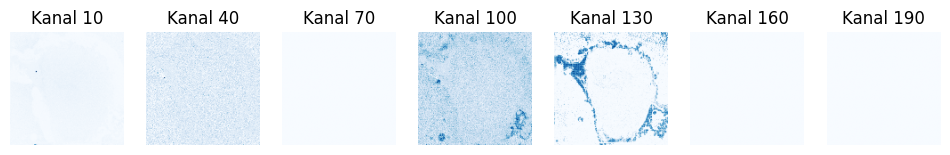

<Figure size 640x480 with 0 Axes>

In [ ]:
# 1. Datensatz laden
data = scipy.io.loadmat("ims_cube.mat")
ims_cube = data['ims_cube'] # Datenwürfel mit x,y Position und m/z als Kanalindex
                            # z = eine Liste an Werten

# eintlich ist es kein Würfel
# Man hat ein 2d Bild mit x und y Werten und zu jedem x und y eine Liste [m/z]

# Man hat ein Objekt, schießt mit 191 verschiedenen Lasereinstellungen drauf
# und speichert dann nach jedem Beschuss pro Pixel den "Rückgabewert"
# dadurch hat man dann 190 mal das gleiche Bild nur mit unterschiedlichen Werten,
# da z.B. einmal Proteine(Kanal 34) und einmal Gelatine(Kanal 47) fokussiert sind
# Also nur der Fokus ist unterschiedlich


# Grundlegende Infos über Struktur des Würfels
print("Datenform:", ims_cube.shape)  # (x, y, kanäle)
print("Datentyp:", ims_cube.dtype)

# 2. Beispielhafte Visualisierung einzelner Kanäle
num_channels = ims_cube.shape[2]

# Die Kanäle für output angeben
channels_to_plot = [10, 40, 70, 100, 130, 160, 190]


# Neue Abbildung mit definierter Größe
plt.figure(figsize=(12, 6))

# Schleife über alle ausgewählten Kanäle
for i, ch in enumerate(channels_to_plot, 1):
    # Lege Position für das aktuelle Teilbild fest (1 Zeile, mehrere Spalten)
    plt.subplot(1, len(channels_to_plot), i)

    # Zeige den jeweiligen Kanal als 2D-Bild
    plt.imshow(ims_cube[:, :, ch], cmap='Blues')
    plt.title(f"Kanal {ch}")  # Beschrifte das Teilbild
    plt.axis('off')           # Achsen ausblenden für saubere Darstellung

# Zeige alle Teilbilder nebeneinander an
plt.show()

plt.suptitle("Räumliche Verteilung ausgewählter Kanäle")
plt.show()


Wie man beobachten kann, beinhalten nicht alle Kanäle viele Informationen. Beispielsweise sind die Features der Kanäle 70, 160 und 190 bei allen Pixeln gleich wenig vorhanden und liefern somit im Kontext einer medizinischen Untersuchung keine Aussage.

Im Folgenden wird dargestellt, wie man für jeden Pixel die relevanten Kanäle erfassen kann. Dafür sind die Intensitäten aller Kanäle an einem Beispielpixel in der Bildmitte geplottet.

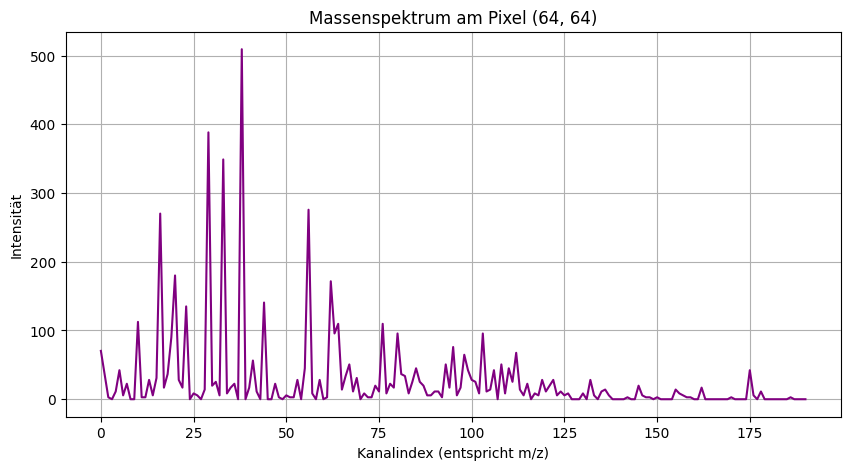

In [4]:
# Beispiel: Pixel in der Mitte des Bildes
row_index, col_index = ims_cube.shape[0] // 2, ims_cube.shape[1] // 2
spectrum = ims_cube[row_index, col_index, :]

plt.figure(figsize=(10, 5))
plt.plot(spectrum, color='purple')
plt.title(f"Massenspektrum am Pixel ({row_index}, {col_index})")
plt.xlabel("Kanalindex (entspricht m/z)")
plt.ylabel("Intensität")
plt.grid(True)
plt.show()


### 2. Datenaufbereitung

Zuerst wandeln wir die Quellmatrix in eine zweidimensionale Matrix um, damit wir eine gewöhnliche Featurematrix mit Features und Datenpunkten erhalten. Dies erleichtert die Handhabung erheblich, vor allem bei ---.

In [6]:
# 3D → 2D Umwandlung
print("Ursprüngliche Form des Datenwürfels:", ims_cube.shape)
spectral_matrix = ims_cube.reshape(-1, ims_cube.shape[2])
print("Form der neuen Featurematrix:", spectral_matrix.shape)


Ursprüngliche Form des Datenwürfels: (128, 128, 191)
Form der neuen Featurematrix: (16384, 191)


Normierung:
Bei der Normierung werden die gemessenen Werte angenähert, sodass das Verhältnis besser betrachtet werden kann. Es könnte zum Beispiel durch Messungenauigkeiten passieren, dass ein Pixel stärker belichtet wurde als ein anderer. In diesem Fall könnten die Intensitäten der Kanäle zum Beispiel so aussehen:

Pixel 1: [10, 20, 30, ...]

Pixel 2: [100, 200, 300, ...]

Diese beiden Pixel sollten bei sinnvollem Clustering ähnlich sein, allerings wäre das nicht der Fall, wenn man nur die absoluten Werte betrachten würde.

Dieser Schritt ist notwendig, da einige von uns evaluierte Cluster-Algorithmen, wie beispielsweise k-means oder [!!! weitere Beispiele ergänzen !!!] zu stark durch große Unterschiede hinsichtlich der Abstände der Daten beeinflusst werden.

--- Analogie zu Alter und Gehalt normieren in Vorlesung? --- 

In [ ]:
# Normierung der Spektren (stabil)
norms = np.linalg.norm(spectral_matrix, axis=1, keepdims=True)

# Vermeidet Division durch 0 (fügt Epsilon hinzu wenn Wert = 0)
norms[norms == 0] = 1e-12

spectral_matrix = spectral_matrix / norms

#"Featureweise Normierung ist sinnvoll"

Feature Selection Motivation:

Features (Kanäle in unserem Fall) die keinen Mehrwert bringen werden gelöscht

Fall: Werte die eine sehr ähnliche Frequenz über alle Kanäle haben wären dann ja einfach so ein Rauschen was auf das Bild keinen Unterschied hätte (Wie ein Grauer Hintergrund der nichts bringt)



In [7]:
# Medianfilter – entfernt lokale Ausreißerpixel pro Kanal
for ch in range(ims_cube.shape[2]):
    ims_cube[:, :, ch] = median_filter(ims_cube[:, :, ch], size=3)

# Signal-zu-Rausch-Filterung (Feature-Selektion)
channel_std = spectral_matrix.std(axis=0)
channel_mean = spectral_matrix.mean(axis=0)
signal_to_noise = channel_mean / (channel_std + 1e-12)

snr_threshold = np.percentile(signal_to_noise, 20)  # unterste 20% entfernen
mask = (channel_std > 1e-6) & (signal_to_noise > snr_threshold)
spectral_matrix = spectral_matrix[:, mask]

print(f"Behaltene Kanäle nach Filterung: {spectral_matrix.shape[1]}")

# Log-Transformation (Varianzstabilisierung)
spectral_matrix = np.log1p(spectral_matrix)


# AUTOMATISCH ERKENNEN WIE VIEL PROZENT WEG SOLLEN
# VARIANZ PRO KANAL NOCH ANZEIGEN LASSEN IRGENDWIE??



Behaltene Kanäle nach Filterung: 152


Extrema sollen verworfen werden, erste Methode: Top 1% Werte einfach rauswerfen -> finde ich schlecht weil wenn [1] = 500;  peaks bei 30% der Pixel hat und [2-191] = 20-25 immer, dann wären die Ausreißer von Kanal [1] ja eine wichtige Struktur aber da sie dann Top 1% wären würden sie einfach rausgelöscht werden.

Deshalb Methode finden die quasi pro Kanal alle Pixel auswertet und wenn dann alle Pixel in diesem Kanal 100-200 haben und ein Pixel dann aufeinmal iwi 800, dann kann man das bei diesem Pixel verändern um die Varianz zu verbessern


In [8]:
# Optional – extreme Ausreißerpixel entfernen
#pixel_std = spectral_matrix.std(axis=1)  # Standardabweichung über alle Kanäle pro Pixel
#mask = pixel_std < np.percentile(pixel_std, 99)  # oberstes 1% verwerfen
#spectral_matrix = spectral_matrix[mask]
#print(f"Behaltene Pixel nach Filterung: {spectral_matrix.shape[0]}")

# AUSREIßER SINNVOLL ENTFERNEN ODER EINFACH LASSEN?

Principal-Component-Analysis(PCA) Motivation

Wir haben oben die Intensität der Kanäle für ein Pixel gesehen.
In unserem Beispiel haben wir lediglich 191 verschiedene Kanäle pro Pixel, allerdings könnten das auch 10.000 sein.

Viele dieser Kanäle sind stark korreliert oder enthalten überwiegend Rauschen.
Die PCA reduziert nicht direkt die Dimension, sondern sie berechnet neue Achsen (Hauptkomponenten), die lineare Kombinationen der ursprünglichen Kanäle darstellen.

Dadurch werden stark korrelierende Kanäle zusammengefasst und nach ihrem Beitrag zur Gesamtvarianz gewichtet.



In [9]:
# Anzahl Hauptkomponenten = alle Kanäle, die nach Filterung übrig bleiben
channel_count = spectral_matrix.shape[1]

# Es geht nichts verloren aber stark korrelierende Daten werden zusammengefasst
# gleiche Anzahl an Kanälen aber einzelne werden deutlich stärker gewichtet
pca = PCA(n_components = channel_count)
spectral_matrix_pca = pca.fit_transform(spectral_matrix)

print("Hauptkomponenten: " + str(spectral_matrix.shape[1]) + " -> noch immer gleich wie oben weil Reduktion noch nicht stattgefunden hat"
                                                             "\n                         nur Gewichtung hat sich intern verändert")



Hauptkomponenten: 152 -> noch immer gleich wie oben weil Reduktion noch nicht stattgefunden hat
                         nur Gewichtung hat sich intern verändert


Varianz

Wie viele Dimensionen nach PCA decken wie viel Prozent aller Daten ab?


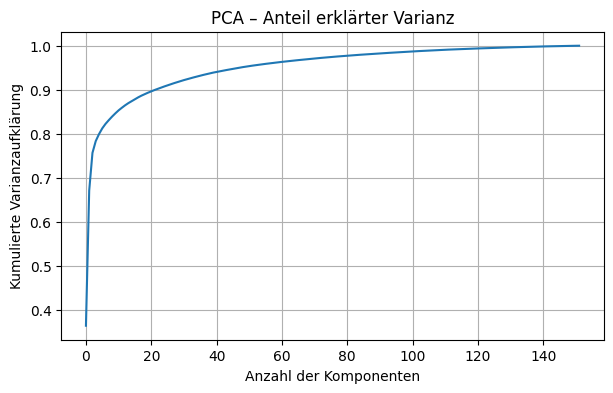

In [10]:
# UMGANGSSPRACHE, NOCH ÄNDERN! "Wie viele Kanäle spiegeln wie viel Prozent der Informationen wieder"
plt.figure(figsize=(7, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Anzahl der Komponenten')
plt.ylabel('Kumulierte Varianzaufklärung')
plt.title('PCA – Anteil erklärter Varianz')
plt.grid(True)
plt.show()


Wichtigste m/z-Kanäle: [ 72  55  34  76  36  91  17  77  53 147]


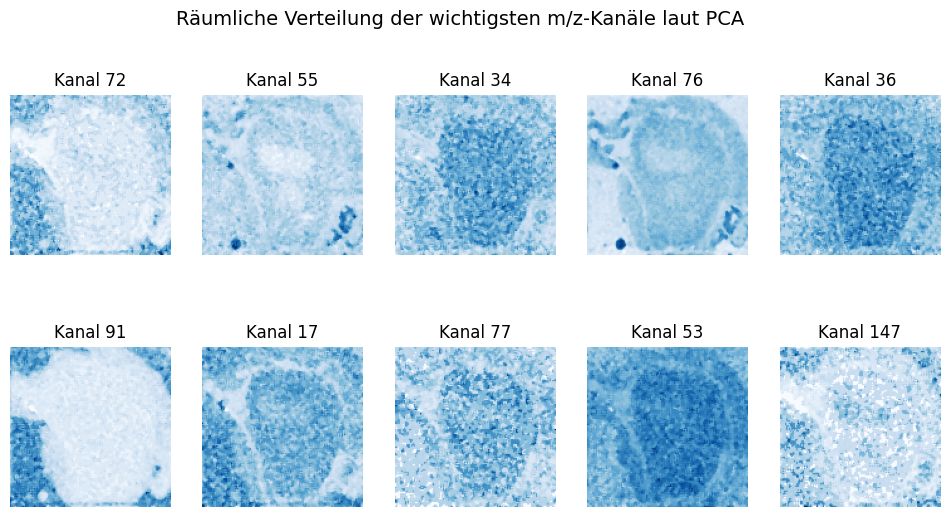

In [11]:
# Wichtigste Kanäle (m/z-Werte) herausfinden
# Wir betrachten hier die erste Hauptkomponente
loadings = np.abs(pca.components_[0])
important_channels = np.argsort(loadings)[-10:][::-1]  # Top 10 mit höchstem Einfluss

print("Wichtigste m/z-Kanäle:", important_channels)

# Diese Kanäle im Bild visualisieren
plt.figure(figsize=(12, 6))
for i, ch in enumerate(important_channels, 1):
    plt.subplot(2, 5, i)
    plt.imshow(ims_cube[:, :, ch], cmap='Blues')
    plt.title(f"Kanal {ch}")
    plt.axis('off')

plt.suptitle("Räumliche Verteilung der wichtigsten m/z-Kanäle laut PCA", fontsize=14)
plt.show()



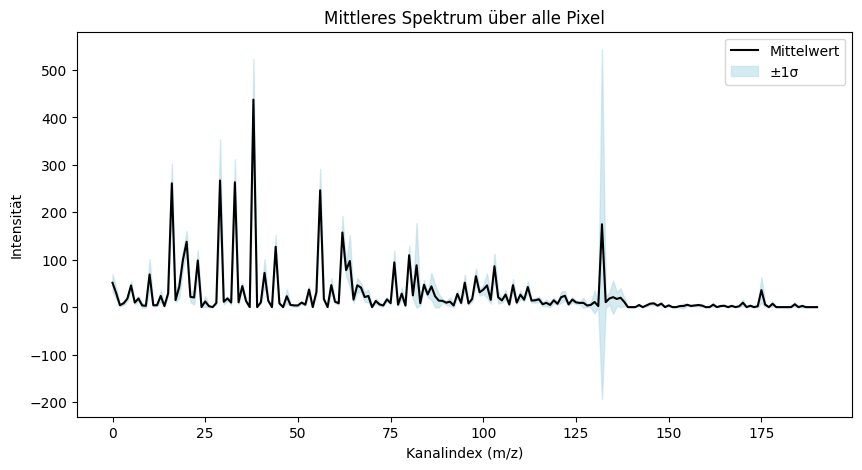

In [12]:
# (Optional) Mittleres Spektrum über alle Pixel + Standardabweichung
mean_spectrum = ims_cube.mean(axis=(0, 1))
std_spectrum = ims_cube.std(axis=(0, 1))

plt.figure(figsize=(10, 5))
plt.plot(mean_spectrum, label='Mittelwert', color='black')
plt.fill_between(range(len(mean_spectrum)),
                 mean_spectrum - std_spectrum,
                 mean_spectrum + std_spectrum,
                 color='lightblue', alpha=0.5, label='±1σ')
plt.title("Mittleres Spektrum über alle Pixel")
plt.xlabel("Kanalindex (m/z)")
plt.ylabel("Intensität")
plt.legend()
plt.show()


Threshold Methode Motivation:

um automatisch die kleinste Anzahl an Kanälen zu wählen um eine gewisse Varianz 'threshold' zu erreichen





In [13]:
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Finde die kleinste Komponentenzahl, die >=95% Varianz erklärt
threshold = 0.95
k_thr = np.searchsorted(cum_var, threshold) + 1  # +1 wegen 0-basiertem Index

print(f"Für {threshold*100:.0f}% erklärte Varianz werden {k_thr} Komponenten benötigt.")

# Daten auf diese k_thr Komponenten reduzieren
spectral_matrix_pca = pca.transform(spectral_matrix)[:, :k_thr]
print("Neue PCA-Form:", spectral_matrix_pca.shape)

Für 95% erklärte Varianz werden 48 Komponenten benötigt.
Neue PCA-Form: (16384, 48)


HIER MAL TESTWEISE K-MEANS EINGEFÜGT EINFACH UM ZU WISSEN WIES AUSSIEHT

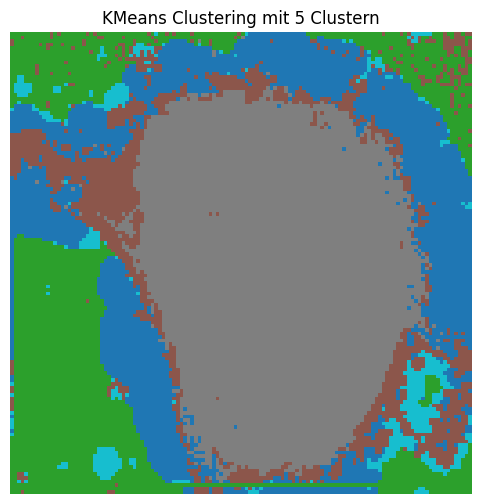

In [14]:
# Clustering – unüberwachtes Lernen auf den MSI-Daten
# Ziel: Ähnliche Pixel anhand ihres Spektrums gruppieren (z. B. Gewebearten)



# --- Schritt 1: Datenreduktion für Clustering ---
# PCA auf z.B. 10 Dimensionen reduzieren (damit KMeans stabiler wird)
spectral_matrix_reduced = spectral_matrix_pca

# --- Schritt 2: KMeans Clustering ---
n_clusters = 5 # Beispiel: 5 Gewebetypen / Regionen
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(spectral_matrix_reduced)

# --- Schritt 3: Zurück in räumliche Form bringen ---
height, width = ims_cube.shape[:2]
cluster_image = cluster_labels.reshape(height, width)

# --- Schritt 4: Ergebnis visualisieren ---
plt.figure(figsize=(6, 6))
plt.imshow(cluster_image, cmap='tab10')
plt.title(f"KMeans Clustering mit {n_clusters} Clustern")
plt.axis('off')
plt.show()


AUFGABE:

in eigenen Worten noch beschreiben wie der Algorithmus

Beste Clusterzahl laut BIC: k=7


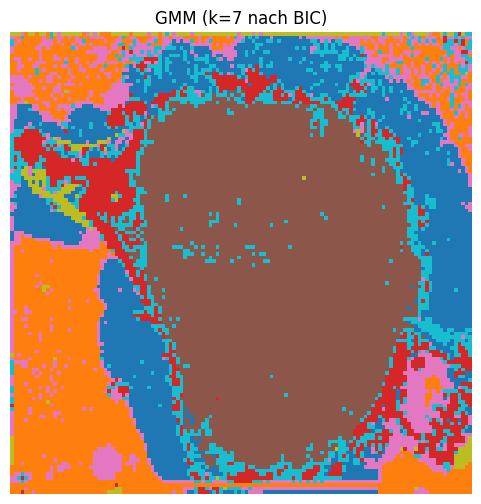

In [15]:
from sklearn.mixture import GaussianMixture
import numpy as np

X = spectral_matrix_pca  # 95%-PCA-Daten
ks = range(2, 9)
bics, gmms = [], []

for k in ks:
    g = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    g.fit(X)
    bics.append(g.bic(X))
    gmms.append(g)

best = np.argmin(bics)
gmm = gmms[best]
labels = gmm.predict(X)
print(f"Beste Clusterzahl laut BIC: k={ks[best]}")

height, width = ims_cube.shape[:2]
plt.figure(figsize=(6,6))
plt.imshow(labels.reshape(height, width), cmap="tab10")
plt.title(f"GMM (k={ks[best]} nach BIC)")
plt.axis('off'); plt.show()



### Quellen:

1. https://de.wikipedia.org/wiki/K-Means-Algorithmus
